In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm #para poder ver las barritas de % cargandose cuando va iterando
from PIL import Image as im

#PyTorch
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [2]:
#Para usar solo 24 cores que me dijo NW

torch.set_num_threads(24)

In [3]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [4]:
# Function to save the model 
def saveModel(model): 
    path = "./Modelos_Fiteados/REG/NUEVAS/3C_L1.pth" 
    torch.save(model.state_dict(), path)

# DATASET

In [5]:
#Bajo el MNIST
datatrain = torchvision.datasets.MNIST('./', train=True, download=True)
datatest = torchvision.datasets.MNIST('./', train=False, download=True)

m=len(datatrain)

train_data, val_data = random_split(datatrain, [int(m-m*0.2), int(m*0.2)])

#Lo guardo en listas en vez de tensores
X_train = [x[0] for x in train_data]
y_train = [x[1] for x in train_data]

X_val = [x[0] for x in val_data]
y_val = [x[1] for x in val_data]

X_test = [x[0] for x in datatest]
y_test = [x[1] for x in datatest]


RX_train = [0]*(20*len(X_train))
RY_train = [0]*(20*len(X_train))

RX_val = [0]*(20*len(X_val))
RY_val = [0]*(20*len(X_val))

RX_test = [0]*(20*len(X_test))
RY_test = [0]*(20*len(X_test))

In [6]:
rotador = torchvision.transforms.functional.rotate

In [7]:
for i in range(len(X_train)):
    for j in range(20):
        ang = random.uniform(-60,60)
        RX_train[i*20+j]=rotador(X_train[i],ang)
        RY_train[i*20+j]=ang
        
for i in range(len(X_val)):
    for j in range(20):
        ang = random.uniform(-60,60)
        RX_val[i*20+j]=rotador(X_val[i],ang)
        RY_val[i*20+j]=ang
    
for i in range(len(X_test)):
    for j in range(20):
        ang = random.uniform(-60,60)
        RX_test[i*20+j]=rotador(X_test[i],ang)
        RY_test[i*20+j]=ang

In [ ]:
print(len(RX_train), len(RX_val), len(RX_test))

In [ ]:
#Veamos si estan masomenos distribuidos
plt.hist(RY_test,10)
plt.title('Histograma de labels')
plt.xlabel('label')
plt.ylabel('Frecuencia')

plt.show() #dibujamos el histograma

In [ ]:
# Plot some samples
fig, axs = plt.subplots(5, 5, figsize=(8,8))
i = 0
for ax in axs.flatten():
    ax.imshow(np.array(RX_train[i*20]), cmap='gist_gray')
    ax.set_title(f'Angle: {RY_train[i*20]}')#{round((RY_train[i*20]),2)}')
    ax.set_xticks([])
    ax.set_yticks([])
    i +=1
#plt.savefig('./Modelos_Fiteados/Imagenes/REG/.png', format='png')
plt.tight_layout()

#### Tensores

In [8]:
#hago la transformacion a tensores
to_tensor = torchvision.transforms.ToTensor()

#los convierto a tensores con la transformacion
tensor_RX_train = [to_tensor(RX_train[i]).unsqueeze(0) for i in range(len(RX_train))]
tensor_RX_train = torch.cat(tensor_RX_train)

tensor_RY_train = torch.Tensor(RY_train).float()
###
tensor_RX_val = [to_tensor(RX_val[i]).unsqueeze(0) for i in range(len(RX_val))]
tensor_RX_val = torch.cat(tensor_RX_val)

tensor_RY_val = torch.Tensor(RY_val).float()
###
tensor_RX_test = [to_tensor(RX_test[i]).unsqueeze(0) for i in range(len(RX_test))]
tensor_RX_test = torch.cat(tensor_RX_test)

tensor_RY_test = torch.Tensor(RY_test).float()

#creo los datatrian y datatest
tensor_datatrain = TensorDataset(tensor_RX_train, tensor_RY_train)
train_loader = DataLoader(tensor_datatrain, batch_size=5000, shuffle=True)

tensor_dataval = TensorDataset(tensor_RX_val, tensor_RY_val)
valid_loader = DataLoader(tensor_dataval, batch_size=5000, shuffle=True)

tensor_datatest = TensorDataset(tensor_RX_test, tensor_RY_test)
test_loader = DataLoader(tensor_datatest, batch_size=1)

### Red 2C

In [ ]:
class Net(nn.Module):    
    def __init__(self,nf):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, nf, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(nf, nf, 3)
        self.fc1 = nn.Linear(nf*12*12, 128)
        self.fc2 = nn.Linear(128, 1)
        self.drop = nn.Dropout(0.25)
        self.soft = nn.Softmax()

    def forward(self, x):
        # Apply net
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

### Red 3C

In [9]:
class Net(nn.Module):
    def __init__(self,nf):
        super(Net,self).__init__()
#         ariquitecture
        self.net = nn.Sequential(nn.Conv2d(in_channels  = 1,        # First convolutional layer
                                           out_channels = nf,
                                           kernel_size  = 3,
                                           stride       = 2,
                                           padding      = 1),
                                 nn.ReLU(True),                     # OUT  [nf X 14 X 14]
                                 nn.Conv2d(in_channels  = nf,        # Second convolutional layer
                                           out_channels = 2 * nf,
                                           kernel_size  = 3,
                                           stride       = 2,
                                           padding      = 1),
                                 nn.ReLU(True),                      # OUT [2nf X 7 X 7]
                                 nn.Conv2d(in_channels  = 2 * nf,     # Third convolutional layer
                                           out_channels = 4 * nf,
                                           kernel_size  = 3,
                                           stride       = 2,
                                           padding      = 0),
                                 nn.ReLU(True),                     # OUT [4nf X 3 x 3]
                                 nn.Flatten(start_dim=1),            # Flatten layer
                                 nn.Linear(in_features  = ((4*nf)*3*3),
                                           out_features = 128),
                                 nn.ReLU(True),
                                 nn.Linear(in_features  = 128,
                                           out_features = 64),
                                 nn.ReLU(True),
                                 nn.Dropout(0.2),
                                 nn.Linear(in_features  = 64,
                                           out_features = 1,
                                           bias=False)
                                )
        
    def forward(self, x):
        # Apply encoder decoder
        x = self.net(x)
        return x

In [10]:
#RED CON 2C
# nf = 64

#RED CON 3C
nf = 8

# Inicializamos la red
REGRESION = Net(nf)

#Definimos la loss function
# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

# Definimos el optimizador
optimizer = torch.optim.Adam(REGRESION.parameters(), lr=0.001 , weight_decay=0.0001)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
REGRESION.to(device)

Selected device: cpu


Net(
  (net): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=128, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=False)
  )
)

In [11]:
### Training function
def train_epoch(REGRESION, device, dataloader, loss_fn, optimizer):
    # Train
    REGRESION.train()
    train_loss = []
    for data, label in dataloader:
        # Move data to device
        data = data.to(device)
        label = label.to(device)
        # process
        processed = REGRESION.forward(data)[:,0]
        # Compute loss
        loss = loss_fn(processed, label)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###
        loss = loss.detach().cpu().numpy()
        train_loss.append(loss)
    return np.mean(train_loss)    

In [12]:
# Testing function
def test_epoch(modelo, device, dataloader, loss_fn):
    modelo.eval()
    test_loss = []
    with torch.no_grad():
        for data, label in dataloader:
            # Move tensor to the proper device
            data = data.to(device)
            label = label.to(device)
            # output
            processed = modelo.forward(data)[:,0]
            # Compute loss
            loss = loss_fn(processed, label)
            #Save test loss for this batch
            loss = loss.detach().cpu().numpy()
            test_loss.append(loss)
    return np.mean(test_loss)

### ENTRENAMOS

In [13]:
num_epochs = 30
diz_loss = {'train_loss_1':[], 'train_loss_2':[], 'val_loss':[]}
for epoch in tqdm(range(num_epochs)):
    train_loss_1 = train_epoch(REGRESION,
                              device,
                              train_loader,
                              loss_fn,
                              optimizer)
    train_loss_2 = test_epoch(REGRESION,
                              device,
                              train_loader,
                              loss_fn)
    val_loss = test_epoch(REGRESION,
                          device,
                          valid_loader,
                          loss_fn)
    print('\n EPOCH {}/{} \t train loss_1 {} \t train loss_2 {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss_1,train_loss_2,val_loss))
    diz_loss['train_loss_1'].append(train_loss_1)
    diz_loss['train_loss_2'].append(train_loss_2)
    diz_loss['val_loss'].append(val_loss)

  3%|██▋                                                                              | 1/30 [00:17<08:31, 17.65s/it]


 EPOCH 1/30 	 train loss_1 18.008089065551758 	 train loss_2 11.624669075012207 	 val loss 11.598091125488281


  7%|█████▍                                                                           | 2/30 [00:35<08:10, 17.53s/it]


 EPOCH 2/30 	 train loss_1 11.103976249694824 	 train loss_2 10.088274955749512 	 val loss 10.031781196594238


 10%|████████                                                                         | 3/30 [00:52<07:57, 17.70s/it]


 EPOCH 3/30 	 train loss_1 10.21946907043457 	 train loss_2 9.376020431518555 	 val loss 9.327181816101074


 13%|██████████▊                                                                      | 4/30 [01:10<07:38, 17.64s/it]


 EPOCH 4/30 	 train loss_1 9.66882610321045 	 train loss_2 8.90971851348877 	 val loss 8.856000900268555


 17%|█████████████▌                                                                   | 5/30 [01:28<07:19, 17.58s/it]


 EPOCH 5/30 	 train loss_1 9.217636108398438 	 train loss_2 8.440796852111816 	 val loss 8.377095222473145


 20%|████████████████▏                                                                | 6/30 [01:45<07:04, 17.70s/it]


 EPOCH 6/30 	 train loss_1 8.844356536865234 	 train loss_2 8.182574272155762 	 val loss 8.11888599395752


 23%|██████████████████▉                                                              | 7/30 [02:06<07:09, 18.68s/it]


 EPOCH 7/30 	 train loss_1 8.54462718963623 	 train loss_2 7.8240065574646 	 val loss 7.770808696746826


 27%|█████████████████████▌                                                           | 8/30 [02:24<06:41, 18.27s/it]


 EPOCH 8/30 	 train loss_1 8.290653228759766 	 train loss_2 7.643348693847656 	 val loss 7.618791103363037


 30%|████████████████████████▎                                                        | 9/30 [02:41<06:21, 18.16s/it]


 EPOCH 9/30 	 train loss_1 8.058269500732422 	 train loss_2 7.315927028656006 	 val loss 7.275676727294922


 33%|██████████████████████████▋                                                     | 10/30 [02:59<05:58, 17.94s/it]


 EPOCH 10/30 	 train loss_1 7.891229152679443 	 train loss_2 7.166639804840088 	 val loss 7.135369777679443


 37%|█████████████████████████████▎                                                  | 11/30 [03:16<05:37, 17.78s/it]


 EPOCH 11/30 	 train loss_1 7.743485927581787 	 train loss_2 7.010566711425781 	 val loss 6.97736120223999


 40%|████████████████████████████████                                                | 12/30 [03:34<05:18, 17.68s/it]


 EPOCH 12/30 	 train loss_1 7.604318141937256 	 train loss_2 6.954761028289795 	 val loss 6.938904285430908


 43%|██████████████████████████████████▋                                             | 13/30 [03:51<04:58, 17.59s/it]


 EPOCH 13/30 	 train loss_1 7.4896016120910645 	 train loss_2 6.782293796539307 	 val loss 6.768157958984375


 47%|█████████████████████████████████████▎                                          | 14/30 [04:09<04:40, 17.53s/it]


 EPOCH 14/30 	 train loss_1 7.376547336578369 	 train loss_2 6.769128322601318 	 val loss 6.747534275054932


 50%|████████████████████████████████████████                                        | 15/30 [04:26<04:22, 17.50s/it]


 EPOCH 15/30 	 train loss_1 7.310678958892822 	 train loss_2 6.5752129554748535 	 val loss 6.564600467681885


 53%|██████████████████████████████████████████▋                                     | 16/30 [04:44<04:06, 17.61s/it]


 EPOCH 16/30 	 train loss_1 7.227987289428711 	 train loss_2 6.518381595611572 	 val loss 6.514507293701172


 57%|█████████████████████████████████████████████▎                                  | 17/30 [05:01<03:48, 17.56s/it]


 EPOCH 17/30 	 train loss_1 7.13933801651001 	 train loss_2 6.377325534820557 	 val loss 6.369981288909912


 60%|████████████████████████████████████████████████                                | 18/30 [05:19<03:30, 17.51s/it]


 EPOCH 18/30 	 train loss_1 7.070188045501709 	 train loss_2 6.366945743560791 	 val loss 6.3720383644104


 63%|██████████████████████████████████████████████████▋                             | 19/30 [05:36<03:12, 17.49s/it]


 EPOCH 19/30 	 train loss_1 7.018987655639648 	 train loss_2 6.221328258514404 	 val loss 6.239734172821045


 67%|█████████████████████████████████████████████████████▎                          | 20/30 [05:54<02:54, 17.49s/it]


 EPOCH 20/30 	 train loss_1 6.963210582733154 	 train loss_2 6.222665309906006 	 val loss 6.25001859664917


 70%|████████████████████████████████████████████████████████                        | 21/30 [06:11<02:38, 17.59s/it]


 EPOCH 21/30 	 train loss_1 6.904149532318115 	 train loss_2 6.1335129737854 	 val loss 6.165740966796875


 73%|██████████████████████████████████████████████████████████▋                     | 22/30 [06:29<02:20, 17.52s/it]


 EPOCH 22/30 	 train loss_1 6.86915397644043 	 train loss_2 6.069699764251709 	 val loss 6.108158588409424


 77%|█████████████████████████████████████████████████████████████▎                  | 23/30 [06:46<02:02, 17.49s/it]


 EPOCH 23/30 	 train loss_1 6.812615871429443 	 train loss_2 6.011474132537842 	 val loss 6.059729099273682


 80%|████████████████████████████████████████████████████████████████                | 24/30 [07:04<01:44, 17.49s/it]


 EPOCH 24/30 	 train loss_1 6.78666877746582 	 train loss_2 6.1550445556640625 	 val loss 6.212731838226318


 83%|██████████████████████████████████████████████████████████████████▋             | 25/30 [07:21<01:27, 17.45s/it]


 EPOCH 25/30 	 train loss_1 6.762554168701172 	 train loss_2 5.978700160980225 	 val loss 6.024515151977539


 87%|█████████████████████████████████████████████████████████████████████▎          | 26/30 [07:39<01:09, 17.46s/it]


 EPOCH 26/30 	 train loss_1 6.6831183433532715 	 train loss_2 5.916120529174805 	 val loss 5.981970310211182


 90%|████████████████████████████████████████████████████████████████████████        | 27/30 [07:56<00:52, 17.57s/it]


 EPOCH 27/30 	 train loss_1 6.643596649169922 	 train loss_2 5.986669063568115 	 val loss 6.059469699859619


 93%|██████████████████████████████████████████████████████████████████████████▋     | 28/30 [08:14<00:35, 17.50s/it]


 EPOCH 28/30 	 train loss_1 6.6217474937438965 	 train loss_2 6.017527103424072 	 val loss 6.092998027801514


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 29/30 [08:31<00:17, 17.50s/it]


 EPOCH 29/30 	 train loss_1 6.56892728805542 	 train loss_2 5.760385990142822 	 val loss 5.835501194000244


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [08:49<00:00, 17.64s/it]


 EPOCH 30/30 	 train loss_1 6.53169059753418 	 train loss_2 5.753641605377197 	 val loss 5.828758716583252


In [16]:
saveModel(REGRESION)

In [ ]:
# model.load_state_dict(torch.load("./Modelos_Fiteados/REG/3C_L1.pth"))

In [14]:
np.savetxt('./Modelos_Fiteados/losses/REG/Nuevas_loss/errorTrain_3CL1_1',diz_loss['train_loss_1'])
np.savetxt('./Modelos_Fiteados/losses/REG/Nuevas_loss/errorTrain_3CL1_2',diz_loss['train_loss_2'])
np.savetxt('./Modelos_Fiteados/losses/REG/Nuevas_loss/errorVal_3CL1',diz_loss['val_loss'])

# train_loss = np.loadtxt('./Modelos_Fiteados/losses/trainloss60_5')
# test_loss = np.loadtxt('./Modelos_Fiteados/losses/testloss60_5')

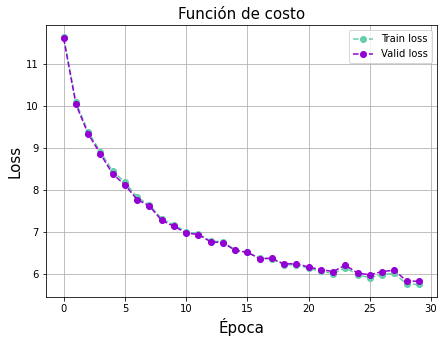

In [15]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
# plt.plot(train_loss_1, linestyle='--', marker='o',  label='Train 1 loss', c='mediumaquamarine')
plt.plot(diz_loss['train_loss_2'], linestyle='--', marker='o',  label='Train loss', c='mediumaquamarine')
plt.plot(diz_loss['val_loss'], linestyle='--', marker='o', label='Valid loss', c='darkviolet')
plt.xlabel('Época',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Función de costo",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Modelos_Fiteados/Imagenes/REG/NUEVAS/errores_3CL1.png', format='png')
plt.show()

In [ ]:
prediccion = []

model.to(device)

with torch.no_grad():
    for data in test_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        
        # forward + backward + optimize
        outputs = model(inputs, "Test")
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        prediccion.append([outputs[0][0],labels[0]])
        #print(outputs)
prediccion = np.array(prediccion)

In [ ]:
# np.savetxt('./Modelos_Fiteados/REG/predic_3C_L1',prediccion)

prediccion = np.loadtxt('./Modelos_Fiteados/REG/predic_3C_L1')

In [ ]:
# plt.figure(figsize=(7,5))
plt.scatter(prediccion[:,1],prediccion[:,0], marker="+", s=1, alpha=.2, c='blueviolet')
plt.plot(np.linspace(-60, 60, num=100),np.linspace(-60, 60, num=100), linestyle='--', c='orange')
plt.xlabel('Valor REAL',fontsize=15)
plt.ylabel('Valor PREDICHO',fontsize=15)
plt.title("Dispersión de valores predichos",fontsize=15)
plt.xlim(-60,60)
plt.savefig('./Modelos_Fiteados/Imagenes/REG/disper_3C_L1.png', format='png')
plt.show()

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.scatter(prediccion[:,0],[i for i in range(len(prediccion[:,0]))],alpha=0.05)
# plt.scatter(prediccion[:,1],[i for i in range(len(prediccion[:,1]))],alpha=0.05)
# plt.show()

### Vamos a discretizar las cosas asi vemos una especie de CM

In [ ]:
prediccion = np.loadtxt('./Modelos_Fiteados/REG/predic_2C_L1')

In [ ]:
i=0
for i in range(len(prediccion)):
    if -60<= prediccion[i,0]< -45:
        prediccion[i,0]=0
    elif -45 <= prediccion[i,0] < -30:
        prediccion[i,0]=1
    elif -30<= prediccion[i,0] < -15:
        prediccion[i,0]=2
    elif -15 <= prediccion[i,0] < 0:
        prediccion[i,0]=3
    elif 0 <= prediccion[i,0] <15:
        prediccion[i,0]=4
    elif 15 <= prediccion[i,0] <30:
        prediccion[i,0]=5
    elif 30 <= prediccion[i,0] <45:
        prediccion[i,0]=6
    else:
        prediccion[i,0]=7        
        
i=0
for i in range(len(prediccion)):
    if -60 <= prediccion[i,1]< -45:
        prediccion[i,1]=0
    elif -45 <= prediccion[i,1] < -30:
        prediccion[i,1]=1
    elif -30<= prediccion[i,1] < -15:
        prediccion[i,1]=2
    elif -15 <= prediccion[i,1] < 0:
        prediccion[i,1]=3
    elif 0 <= prediccion[i,1] <15:
        prediccion[i,1]=4
    elif 15 <= prediccion[i,1] <30:
        prediccion[i,1]=5
    elif 30 <= prediccion[i,1] <45:
        prediccion[i,1]=6
    else:
        prediccion[i,1]=7

In [ ]:
label = prediccion[:,0]
pred = prediccion[:,1]

In [ ]:
def confussion_plot(real, prediction):
    categories = ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5', 'Clase 6', 'Clase 7', 'Clase 8']

    array = confusion_matrix(real, prediction)#, normalize="true")
    df_cm = pd.DataFrame(array, index = [i for i in categories], columns = [i for i in categories])
    
    fig = plt.figure(figsize=(8,7))
    sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis')
    plt.ylabel("Etiqueta",fontsize=15)
    plt.xlabel("Predicción",fontsize=15)
    plt.title("Matríz de confusión",fontsize=15)
    plt.savefig('./Modelos_Fiteados/Imagenes/REG/CM_2C_L1.png', format='png')
    plt.show()

In [ ]:
confussion_plot(label, pred)

In [ ]:
right = 0
test_acc = 0

for i in range(len(label)):
    right = np.sum(label[i]==pred[i])
    test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(label)*100} %")

en 5 clases a ver

In [ ]:
prediccion = np.loadtxt('./Modelos_Fiteados/REG/predic_3C_L1')

In [ ]:
i=0
for i in range(len(prediccion)):
    if -60<= prediccion[i,0]< -36:
        prediccion[i,0]=0
    elif -36 <= prediccion[i,0] < -12:
        prediccion[i,0]=1
    elif -12<= prediccion[i,0] < 12:
        prediccion[i,0]=2
    elif 12 <= prediccion[i,0] < 36:
        prediccion[i,0]=3
    else:
        prediccion[i,0]=4        
        
i=0
for i in range(len(prediccion)):
    if -60 <= prediccion[i,1]< -36:
        prediccion[i,1]=0
    elif -36 <= prediccion[i,1] < -12:
        prediccion[i,1]=1
    elif -12<= prediccion[i,1] < 12:
        prediccion[i,1]=2
    elif 12 <= prediccion[i,1] < 36:
        prediccion[i,1]=3
    else:
        prediccion[i,1]=4

In [ ]:
label = prediccion[:,0]
pred = prediccion[:,1]

In [ ]:
def confussion_plot(real, prediction):
    categories = ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5']

    array = confusion_matrix(real, prediction, normalize="true")
    df_cm = pd.DataFrame(array, index = [i for i in categories], columns = [i for i in categories])
    
    fig = plt.figure(figsize=(8,7))
    sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis')
    plt.ylabel("Etiqueta",fontsize=15)
    plt.xlabel("Predicción",fontsize=15)
    plt.title("Matríz de confusión",fontsize=15)
    plt.savefig('./Modelos_Fiteados/Imagenes/REG/MC3CL1_5_NORM.png', format='png')
    plt.show()

In [ ]:
confussion_plot(label, pred)

#### Veamos si me sale el grafico delas cosas pero con la recta ajustada

In [ ]:
a = -0.0064
b = 1.009

x = np.arange(-0.6,0.6, 0.001)
y = a + b*x

# plt.plot(x,y)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Lab DLS')
# plt.show()

In [ ]:
prediccion = np.loadtxt('./Modelos_Fiteados/REG/predic_')

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(prediccion[:,0],prediccion[:,1], marker="+", color='navy', s=5, alpha=.2)
plt.plot(np.linspace(-0.6, 0.6, num=100),np.linspace(-0.6, 0.6, num=100), linestyle='--', color='sandybrown')
plt.scatter(x,y, marker ='*' , color = 'darkviolet', s=5, alpha=0.5)
plt.xlabel('Valor predicho',fontsize=15)
plt.ylabel('Valor real',fontsize=15)
plt.title("Dispersión 2C_L1",fontsize=15)
plt.xlim(-0.8,0.8)
plt.legend(labels = ['Puntos','Identidad','Ajuste'])
# plt.savefig('./Modelos_Fiteados/Imagenes/REG/disper_3c_L1.png', format='png')
plt.show()